In [76]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import json
from shapely import wkb
print(os.getcwd())

from neo4j import GraphDatabase
import psycopg2
from shapely.geometry import Point

/home/jovyan/work/business-opportunity-graph/notebooks


In [91]:
#from gemini

def get_degrees(tx, node_label: str = None, rel_type: str = None) -> dict[int, int]:
    # Construct the node pattern: (n) if node_label is None/empty, or (n:Label) otherwise
    node_pattern = f"(n{f':{node_label}' if node_label else ''})"

    # Construct the relationship pattern: -[]- if rel_type is None/empty, or -[:TYPE]- otherwise
    rel_pattern = f"-[r{f':{rel_type}' if rel_type else ''}]-"

    query = f"""
    MATCH {node_pattern}{rel_pattern}()
    RETURN elementId(n) as id, count(r) as degree
    """
    
    result = tx.run(query)
    # The result.data() method returns a list of dictionaries, 
    # e.g., [{'id': '4:0', 'degree': 5}, {'id': '4:1', 'degree': 3}]
    res = result.data()
    return res

In [90]:
#functions from Graph Data Science with Neo4J by Estelle Scifo
def get_degrees(tx, node_label: str, rel_type: str) -> dict[int, int]:
    query = f"""
    MATCH (n:{node_label})-[r:{rel_type}]-() 
    RETURN elementId(n) as id, count(r) as degree
    """
    result = tx.run(query)
    res = result.data()
    return res



def plot_degree_distribution(degrees: pd.Series):
    # define figure and subplots
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.subplots(1, 1)

    # compute and draw degree distribution
    distribution = degrees.value_counts().sort_index()
    distribution.plot(
        ax=ax1, 
        marker="o", color="k",
        title="Degree Distribution", xlabel="Degree", ylabel="nbOccurrences",
        logy=True, 
        logx=True,
    )

    fig.tight_layout()
    return fig



In [23]:
SD_crs = 'EPSG:26946'
common_crs = "EPSG:4326"


data_path = '../data/'



In [77]:
# Setup remote group neo4j instance with the following credentials
# This is the database we will write to and use in our project
group_driver = GraphDatabase.driver(
     "bolt://67.58.49.87:7687",
     auth=("neo4j", "h2u9l4px")
)


# group_driver = GraphDatabase.driver(
#      os.getenv("NEO4J_URI_GROUP"),
#      auth=(os.getenv("NEO4J_USER_GROUP"), os.getenv("NEO4J_PASSWORD_GROUP"))
# )
with group_driver.session() as session:
    result = session.run("MATCH (n) UNWIND labels(n) AS label RETURN count(DISTINCT label) AS count")
    num_nodes = result.single()["count"]
    print(f"Connection Successful: {num_nodes} unique node types found in the graph database")

Connection Successful: 10 unique node types found in the graph database


[{'id': '4:f138a071-9a96-444f-b874-ea6c62582d80:33186', 'degree': 3}, {'id': '4:f138a071-9a96-444f-b874-ea6c62582d80:73876', 'degree': 15}, {'id': '4:f138a071-9a96-444f-b874-ea6c62582d80:33187', 'degree': 2}]


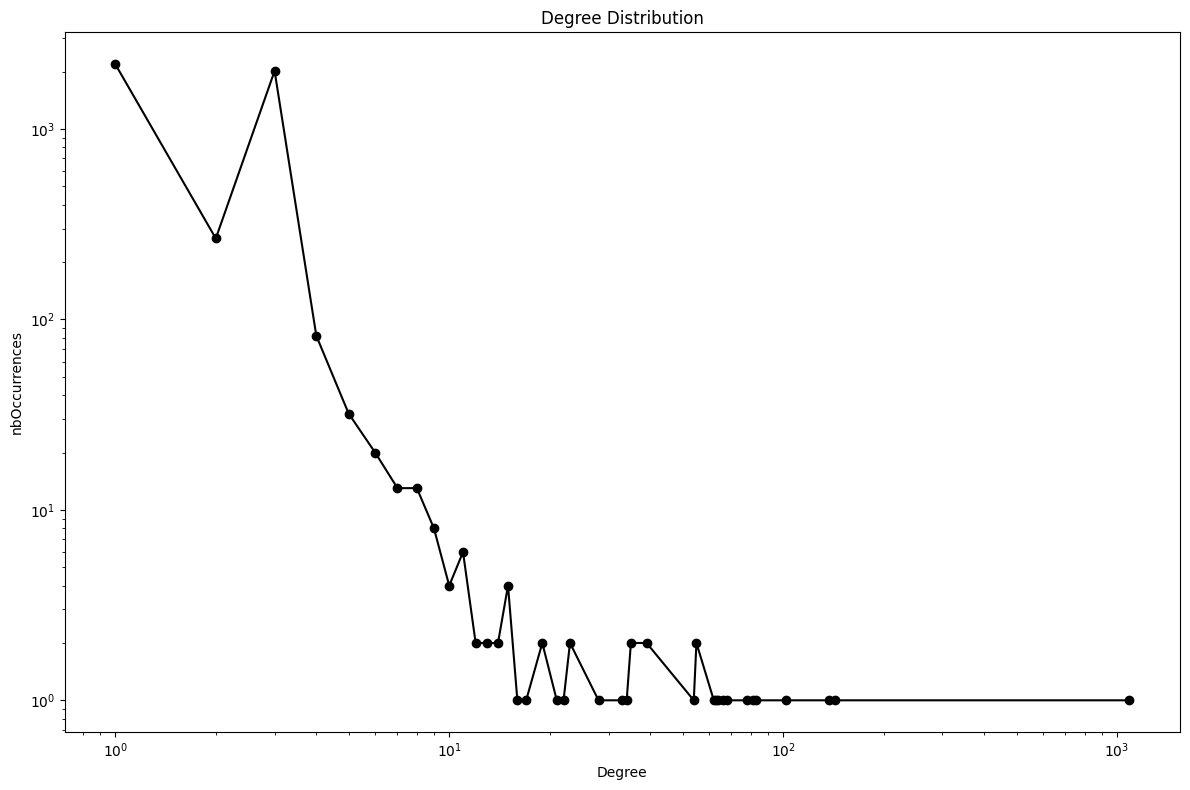

In [97]:
with group_driver.session() as s:
    # degree_data = s.read_transaction(get_degrees, "Person", "KNOWS")
    # degree_data = s.execute_read(get_degrees, "BusinessLocation", "contained_in")
    degree_data = s.execute_read(get_degrees)    
print(degree_data[:3])


data = pd.DataFrame(degree_data)

plot_degree_distribution(data.degree);

In [74]:
# Geodataframes

In [54]:

boundaries_zip = 'City_and_County_Boundaries.zip'
boundaries_path = os.path.join(data_path, boundaries_zip)
boundaries_gdf = gpd.read_file(boundaries_path)



communities_csv = 'sd_community_boundaries.csv'
communities_path = os.path.join(data_path, communities_csv)
communities = gpd.read_file(communities_path)
communities_gdf = gpd.GeoDataFrame(
    geometry=gpd.GeoSeries.from_wkt(communities['geometry'], crs=common_crs), data=communities
)
communities_gdf = communities_gdf.rename(columns={'name': 'community'})



business_location_df = pd.read_json("../data/business_location.json")
business_location_geometry = [Point(xy) for xy in zip(business_location_df.longitude, df.latitude)]
business_location_gdf = gpd.GeoDataFrame(business_location_df, crs="EPSG:4326", geometry=geometry)
business_location_gdf = business_location_gdf[business_location_gdf['longitude']!=180] #fix these outliers


block_group_df = pd.read_json("../data/block_group.json")


In [55]:
boundaries_gdf = boundaries_gdf.to_crs(common_crs)
communities_gdf = communities_gdf.to_crs(common_crs)



In [57]:
sd_boundaries_gdf = boundaries_gdf[boundaries_gdf['COUNTY_NAM'] == 'San Diego']
sd_boundaries_mixed = sd_boundaries_gdf[['CITY','geometry']]

sd_cities_boundaries_gdf= sd_boundaries_mixed.rename(columns={"CITY": "City"}).dissolve(by= 'City').reset_index()


/tmp/ipykernel_1798/995617816.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(communities_gdf.geometry.centroid.x,
/tmp/ipykernel_1798/995617816.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  communities_gdf.geometry.centroid.y,


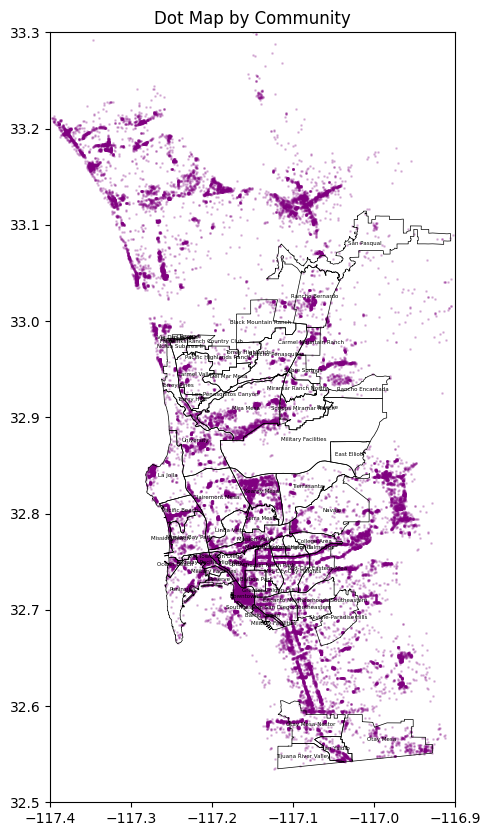

In [61]:
fig1, ax = plt.subplots(figsize=(10, 10))
bus_loc_plot = business_location_gdf.plot(ax=ax, color='purple',markersize=1, alpha=0.2)
communities_gdf.plot(color = 'none', ax=ax, edgecolor='black', linewidth=0.5)#, norm=norm)

bus_loc_plot.set_xlim(-117.4,-116.9)
bus_loc_plot.set_ylim(32.5,33.3)


for x, y, label in zip(communities_gdf.geometry.centroid.x,
                      communities_gdf.geometry.centroid.y,
                      communities_gdf['community']):

        ax.text(x, y, label, fontsize=4, ha='center', va='center')

ax.set_title('Dot Map by Community')

plt.show()



/tmp/ipykernel_1798/3718475123.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(sd_cities_boundaries_gdf.geometry.centroid.x,
/tmp/ipykernel_1798/3718475123.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sd_cities_boundaries_gdf.geometry.centroid.y,


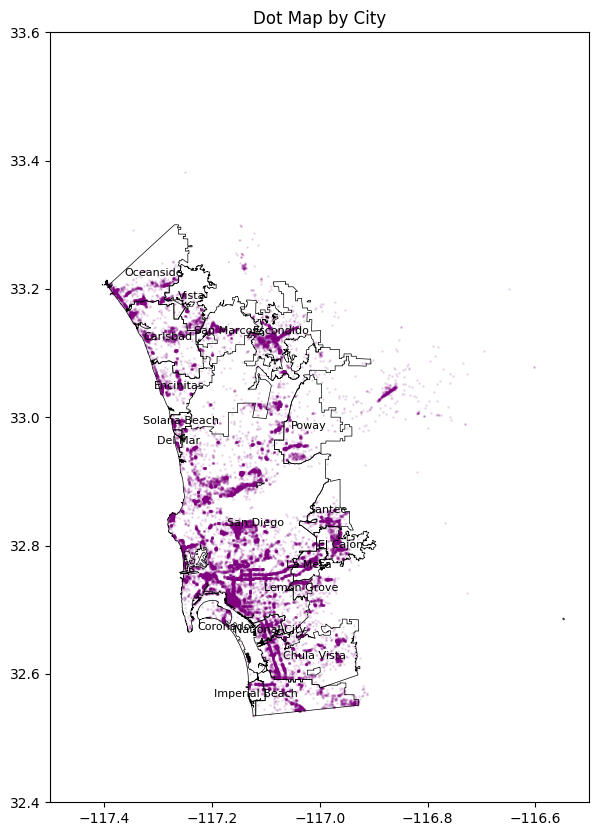

In [72]:
fig2, ax2 = plt.subplots(figsize=(10, 10))
bus_loc_cities_plot = business_location_gdf.plot(ax=ax2, color='purple',markersize=1, alpha=0.1)
sd_cities_boundaries_gdf.plot(color = 'none', ax=ax2, edgecolor='black', linewidth=0.5)#, norm=norm)

bus_loc_cities_plot.set_xlim(-117.5,-116.5)
bus_loc_cities_plot.set_ylim(32.4,33.6)


for x, y, label in zip(sd_cities_boundaries_gdf.geometry.centroid.x,
                      sd_cities_boundaries_gdf.geometry.centroid.y,
                      sd_cities_boundaries_gdf['City']):

        ax2.text(x, y, label, fontsize=8, ha='center', va='center')

ax2.set_title('Dot Map by City')

plt.show()



In [17]:
business_location_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 39593 entries, 0 to 39592
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          39593 non-null  int64   
 1   name        39593 non-null  object  
 2   url         39593 non-null  object  
 3   address     39593 non-null  object  
 4   city        39527 non-null  object  
 5   zip         39593 non-null  int64   
 6   latitude    39593 non-null  float64 
 7   longitude   39593 non-null  float64 
 8   blockgroup  39556 non-null  float64 
 9   categories  39424 non-null  object  
 10  avg_rating  39571 non-null  float64 
 11  franchise   39593 non-null  object  
 12  confidence  39593 non-null  float64 
 13  reasoning   39593 non-null  object  
 14  geom        39593 non-null  object  
 15  geometry    39593 non-null  geometry
dtypes: float64(5), geometry(1), int64(2), object(8)
memory usage: 5.1+ MB


<Axes: >

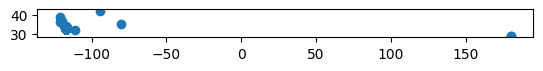

In [16]:
business_location_gdf.plot()
